<a href="https://colab.research.google.com/github/EllDy96/MAE_Thesis/blob/main/sEMG_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the libraries and creating a connection wiht my google drive to import the Datasets.

In [ ]:
#!pip install tensorflow==2.12.0
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
  #raise SystemError('GPU device not found')    
else:
  print('I Found a GPU! at: {}'.format(device_name))
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sklearn
import pandas as pd
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Reshape , Dropout
from sklearn import preprocessing
from keras.regularizers import l1
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
plt.style.use('seaborn')

from google.colab import drive
drive.mount('/content/drive') # now I can import files from my Drive

I Found a GPU! at: /device:GPU:0


<ipython-input-12-549338ee2200>:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!nvidia-smi # it list the availabe GPUs

# Better to use a LSTM 
We want to track a time series input data, better handle by LSTM Recurrent NN. Now let's try to implment it 
First, I need to define your LSTM model architecture using Keras. The architecture can be defined using the Sequential API in Keras. 

In my case I have an 8  input channel, each linked to a specific sEMG stream coming from a specific muscle.In DL the column of the training set are called features, hence I have 8 feautures. 
To enable the LSTM network to keep track of the different activation amounts between the eight channels we need to define a input Dense layer whit shape (num_smaple, 8). We feed each of the 8 neurons whit a specific channel. Then we add a LSTM with 64 neurons and a final Dense layer with 5 neurons and a sigmoid activation function to span the result from 0 to one. the sigmoid function maps any real-valued number to a value between 0 and 1, it is a commonly used nonlinear activation function in neural networks. It is defined as:

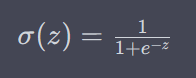



### Importing the sEMG pandas datasets


 
To define the target set, it is necessary to ensure that its first dimension matches that of the training set (the number of rows). We have a training set of shape(num_samples,1, 8), it means with 8 features each wiht dimension 1. We want to have a 5 floats outputs so we need to define a target set of num_sample rows and 5 targets (5 output features). 

The training set and the target set has to have the same number of rows, in this case we select 30000 rows that rappresents 30000 time steps of 8 sample each. 

In [ ]:
#completare con valori sensati
target_dict = {
    'arpeggio': np.array([0.5,0.3, 0.2, 0.3, 0.5]),
    'strumming': np.array([0.6,0.2, 0.8, 0.7, 0.3]),
    'bending': np.array([0.2,0.1, 0.1, 0.5, 0.2]),
    'strongPick': np.array([0.4,0.5, 0.3, 0.4, 0.1]),
    'tapping': np.array([0.3,0.2, 0.6, 0.6, 0.7]),
    'pullOffHammerOn': np.array([0.7,0.7, 0.8, 0.2, 0.4]),
    'doublePick': np.array([0.8,0.4, 0.9, 0.1, 0.8]),
}
#populate the dictionaty with the right shapes before using them as target set
# i have to create a target set with 8 rows and 5 columns 
for i in target_dict:  
  target_dict[i]= np.tile(target_dict[i], (30000,1))

print([i.shape for i in target_dict.values()])

[(30000, 5), (30000, 5), (30000, 5), (30000, 5), (30000, 5), (30000, 5), (30000, 5)]


## Data Preprocessing

In [ ]:
pd_dataframe= {
    'arpeggio': pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe/df_arpeggio_rms'),
    'strumming': pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe/df_strumming_rms'),
    'bending': pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe/df_bending_rms'),
    'doublePick':pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe/df_doublePick_rms'),
    'strongPick':pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe/df_strongPick_rms'),
    'tapping':pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe/df_tapping_rms'),
    'pullOffHammerOn': pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sEMG_pandas_dataset/csv_pd_dataframe/df_pullOffHammerOn_rms')
}
scaler = MinMaxScaler()
#shaping all the pd dataset to a (30000, 8)
for i in pd_dataframe:
  pd_dataframe[i]= pd_dataframe[i].iloc[5000:35000].values # excluding the first and the last 5 second of samples
  pd_dataframe[i] = scaler.fit_transform(pd_dataframe[i])
  pd_dataframe[i]= np.reshape(pd_dataframe[i],(pd_dataframe[i].shape[0], 1, pd_dataframe[i].shape[1]))
print('The lenght and shapes of my training datasets = {}, {}'.format(len(pd_dataframe), [pd_dataframe[key].shape for key in pd_dataframe]))

#Printing some statistics 
for i in pd_dataframe.keys():
  print('mean and variance of', i ,' = {:.3f}, {:.3f}'.format(np.mean(pd_dataframe[i]), np.var(pd_dataframe[i])))


The lenght and shapes of my training datasets = 7, [(30000, 1, 8), (30000, 1, 8), (30000, 1, 8), (30000, 1, 8), (30000, 1, 8), (30000, 1, 8), (30000, 1, 8)]
mean and variance of arpeggio  = 0.240, 0.027
mean and variance of strumming  = 0.310, 0.037
mean and variance of bending  = 0.116, 0.032
mean and variance of doublePick  = 0.314, 0.050
mean and variance of strongPick  = 0.255, 0.037
mean and variance of tapping  = 0.289, 0.032
mean and variance of pullOffHammerOn  = 0.162, 0.028


## Training dataset packing
Here I pack my input data to feed them to the Model during the training process. Furthemore we split the Training dataset in two part, one for the training process and one for the evalution, called Test set.

In [ ]:
"""
train_data= [(pd_dataframe['arpeggio'], target_dict['arpeggio']),
             (pd_dataframe['strumming'], target_dict['strumming']),
             (pd_dataframe['doublePick'], target_dict['doublePick']),
             (pd_dataframe['tapping'], target_dict['tapping']),
             (pd_dataframe['strongPick'], target_dict['strongPick']),
             (pd_dataframe['pullOffHammerOn'], target_dict['pullOffHammerOn'])]
"""
concatenated_training_datasets= np.concatenate(([pd_dataframe[key] for key in pd_dataframe.keys()]),axis=0)
#print(x_train.shape)
concatenated_target_datasets= np.concatenate(([target_dict[key] for key in target_dict.keys()]), axis= 0)
#print(y_train.shape)
#splitting the dataset into a training and testing dataset



X_train, X_test, Y_train, Y_test = train_test_split(concatenated_training_datasets, concatenated_target_datasets, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(168000, 1, 8) (42000, 1, 8) (168000, 5) (42000, 5)


It does not have any senso to put as a imput layer a dense layer. it distracts the LSTM from the time-series analysis, the input layer before the lstm is usualy used when you have a higher values of input features, and you want to do some inference before classify the time series data. The input dense of CNN layer is used to reduce the number of features (parameters) before feed the LSTM. In this case we do not need to use a input dense layer because the number of features is low. We can use it after the LSTM if it encrease the performance. 

In [ ]:

n_features = 8 # each time step has 1 feauture
time_steps = #how many rows you want to elaborate togheter as a single time-stemp, if you want to track patter over time the time_stemps shold be larger

input_shape= (time_steps, n_features)# each sample of new data is rappresented by 8 time steps in our dataset and each time step has feauture shape of 1
#n_features is the number of features or variables at each time step.

# create the input layer with 8 neurons
#input_layer = Input(shape=input_shape)

# pass the dataframe to the input layer
#input_data = input_layer(df.values)

#model = Sequential()
#model.add(Dense(num_input_channels, input_shape=(time_steps, 8), activaction= 'relu'))
#model.add(LSTM(64))
#model.add(Dense(5, activation='sigmoid'))  
"""
model = keras.Sequential([
    layers.Flatten(input_shape=(8,1)),
    layers.Dense(32, activation='relu'),
    layers.LSTM(64),
    layers.Dense(5, activation='sigmoid')
])      
"""
model = Sequential()
#By setting the input shape to (8, 1), you are specifying that each sample consists of 8 time steps, each time step consisting of a single feature
# Add an input dense layer with 8 neurons, one for each column in the input dataset
#I can train the model w
#model.add(Dense(8, input_shape= (1,8)))

# Add an LSTM layer with 64 units
model.add(LSTM(64, input_shape= (30,8),return_sequences=True, kernel_regularizer=l1(0.1))) # when you want to stack multiple LSTM 
#you have to set the return_sequences=True to not have shape problems. 

model.add(Dropout(0.3))  # add a dropout layer with dropout rate of 0.2
model.add(LSTM(64))
# Add a dense output layer with 5 units and linear activation
model.add(Dense(5, activation='linear')) #return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence. Default: False. IT should be set true only in the output layer 

print('The output shape: ',model.output_shape)
model.summary()

The output shape:  (None, 1, 5)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 1, 64)             18688     
                                                                 
 dropout_4 (Dropout)         (None, 1, 64)             0         
                                                                 
 dense_4 (Dense)             (None, 1, 5)              325       
                                                                 
Total params: 19,013
Trainable params: 19,013
Non-trainable params: 0
_________________________________________________________________


### Compiling the Model 
To compile the network (before training it) we have to choose the Optimizer and the loss function: 

The optimizer is the algorithm used to update the weights of the model during training, and 'adam' is a popular optimizer that adapts the learning rate of each weight based on the first and second moments of the gradients.

The loss function is used to measure how well the model is performing on the training data and guides the optimization process. 'mse' stands for mean squared error, which is a common loss function used for regression problems where the goal is to minimize the difference between the predicted and actual values.

Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

Learning rate: The learning rate determines how much the model weights are updated during training. A larger learning rate can lead to faster convergence, but can also cause the model to overshoot the minimum.

Showing the availables parameters of the network

In [ ]:
# Compile the model

#model.compile(optimizer='adam', loss='mse', metrics=['mse'])
myOptimizer = keras.optimizers.Adam(lr=0.01)
model.compile(optimizer= myOptimizer, loss='mse', metrics=['mse'])

### Training the model


In [ ]:
"""
# Load data from pandas dataframe dictionary
X_1 = pd_dataframe['arpeggio'] # Return a Numpy representation of the DataFrame. Only the values in the DataFrame will be returned, the axes labels will be removed.
#print(type(X_1))
X_1= tf.stack(X_1)
y_1 = target_dict['arpeggio']

X_2 = pd_dataframe['strumming'] # Return a Numpy representation of the DataFrame. Only the values in the DataFrame will be returned, the axes labels will be removed.
print(type(X_2))
X_2= tf.stack(X_2)
y_2 = target_dict['strumming']
print('output shape ', y_1.shape, ' input shape  ', X_1.shape )
"""
#print( [pd_dataframe[key] for key in pd_dataframe.keys()])

# Fit the model with different datates each associated to a specific output target
#create a list of datasets tuple to train the model 





history = model.fit(X_train,Y_train, validation_split=0.25, epochs=75)

#bath_size 
#history_2 = model.fit(pd_dataframe['strumming'], target_dict['strumming'], validation_split=0.2,epochs=10, batch_size=32)
#history_3 = model.fit(pd_dataframe['doublePick'], target_dict['doublePick'], validation_split=0.2,epochs=10, batch_size=32)
#history_4 = model.fit(pd_dataframe['tapping'], target_dict['tapping'], validation_split=0.2,epochs=10, batch_size=32)
#history_5 = model.fit(pd_dataframe['strongPick'], target_dict['strongPick'], validation_split=0.2,epochs=10, batch_size=32)
#history_6 = model.fit(pd_dataframe['pullOffHammerOn'], target_dict['pullOffHammerOn'], validation_split=0.2,epochs=10, batch_size=32)








Epoch 1/75
3938/3938 [==============================] - 36s 7ms/step - loss: 0.2831 - mse: 0.0548 - val_loss: 0.0757 - val_mse: 0.0528
Epoch 2/75
3938/3938 [==============================] - 26s 7ms/step - loss: 0.0761 - mse: 0.0529 - val_loss: 0.0758 - val_mse: 0.0526
Epoch 3/75
3938/3938 [==============================] - 26s 7ms/step - loss: 0.0760 - mse: 0.0528 - val_loss: 0.0762 - val_mse: 0.0528
Epoch 4/75
3938/3938 [==============================] - 26s 7ms/step - loss: 0.0760 - mse: 0.0528 - val_loss: 0.0760 - val_mse: 0.0527
Epoch 5/75
3938/3938 [==============================] - 24s 6ms/step - loss: 0.0761 - mse: 0.0528 - val_loss: 0.0760 - val_mse: 0.0526
Epoch 6/75
3938/3938 [==============================] - 25s 6ms/step - loss: 0.0761 - mse: 0.0528 - val_loss: 0.0756 - val_mse: 0.0527
Epoch 7/75
3938/3938 [==============================] - 27s 7ms/step - loss: 0.0761 - mse: 0.0528 - val_loss: 0.0767 - val_mse: 0.0527
Epoch 8/75
3938/3938 [==============================] -

KeyboardInterrupt: ignored


The validation_split argument in Keras fit method specifies the fraction of the training data to be used as validation data. The model will not be trained on the validation data, but rather the validation data will be used to evaluate the model's training performance over the epochs on data it has not seen before.

For example, if validation_split=0.2, then 20% of the training data will be used as validation data and the remaining 80% will be used as the training data. The validation data will be used to evaluate the model's performance after each epoch during training. The validation set is a portion of the training set to evaluate the training process, instead to evaluate the network we have to use a different dataset called testing dataset.

In [ ]:
# list all data in training history
print(history.history.keys())


NameError: ignored

### Plotting the Loss function and the MSE
We can track the training accurancy to avoid overfitting by plotting the loss function and the MSE for each epoch. The MSE is a common metric to evaluate regession task. The lower the loss, the better the model performance. The purpose of the loss function is to evaluate how well the model is learning the patterns in the data and adjusting its weights and biases to make accurate predictions. So, when you train a model, you try to minimize the loss function by adjusting the model's parameters. In other evaluation metrics, such as accuracy or F1 score, the higher the value, the better the model performance.
Ploting the training history

<ipython-input-10-75ebb92dacfa>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


NameError: ignored

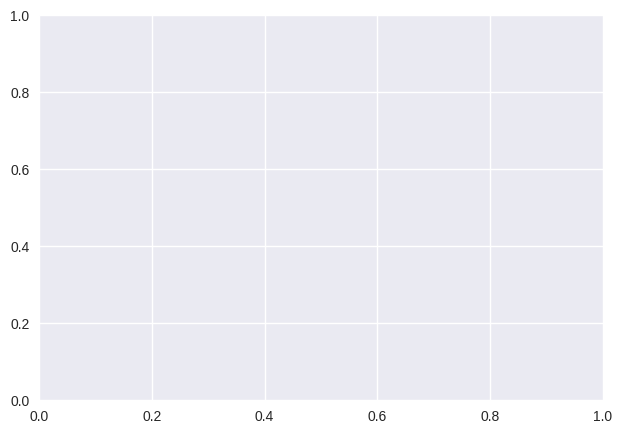

In [ ]:

plt.figure(figsize=(16,5))
plt.title('arpeggio')
plt.subplot(1,2,1)

# summarize history for accuracy
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1,2,2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

## Model Evaluation 
Testing the model whit a testing set computing the loss function for an unseen dataset. 

In [ ]:
#divide in training set e test 
#the testing dataset have to be useen data but whith a trained target set, you can use a dataset belonging to a target that you did not train. 
#in the training the network see the label, in the tasting set it see the label only at the end, but shold be data from a studied label otherwise it has no sense. 
#it has to be data belonging to one of the category which you use during the training but unseen during the training stage.
#you have to split the training dataset to obtai a testing dataset 

## Model evaluation 
model.evaluate(X_test,Y_test)

Now we have to actualy try the regression, we could use the method model.predict

In [ ]:
# Reshape the data to match the input shape of the model
new_data= pd_dataframe['bending'][2]

new_data= np.reshape(new_data,(1,new_data.shape[0], new_data.shape[1]))
print(new_data.shape)
#new_data = new_data.reshape(1, -1)

# Make a prediction using the model
prediction = model.predict(new_data)
print(prediction, prediction.shape)

## Exporting the model 
Now we want to save the model to use it in RawPower


In [ ]:
# Save the model
model.save('sEMG_regression.h5')

be sure to have alla the requirements to run the model 

In [ ]:
!pip freeze > requirements.txt
!pip freeze

## Further implementations 

To keep track of the patterns of each single channel separately, you can use a multichannel LSTM model. This model has separate LSTM cells for each channel, which can learn to extract relevant features from the channel's data independently. You can then combine the outputs from each channel's LSTM cell to produce a final output.

In [ ]:

"""
# Define input shape for each channel
input_shape = (timesteps, features_per_channel)

# Define input layers for each channel
input_channel1 = Input(shape=input_shape, name='input_channel1')
input_channel2 = Input(shape=input_shape, name='input_channel2')
input_channel3 = Input(shape=input_shape, name='input_channel3')
input_channel4 = Input(shape=input_shape, name='input_channel4')
input_channel5 = Input(shape=input_shape, name='input_channel5')
input_channel6 = Input(shape=input_shape, name='input_channel6')
input_channel7 = Input(shape=input_shape, name='input_channel7')
input_channel8 = Input(shape=input_shape, name='input_channel8')

# Define LSTM layers for each channel
lstm_channel1 = LSTM(32, return_sequences=True)(input_channel1)
lstm_channel2 = LSTM(32, return_sequences=True)(input_channel2)
lstm_channel3 = LSTM(32, return_sequences=True)(input_channel3)
lstm_channel4 = LSTM(32, return_sequences=True)(input_channel4)
lstm_channel5 = LSTM(32, return_sequences=True)(input_channel5)
lstm_channel6 = LSTM(32, return_sequences=True)(input_channel6)
lstm_channel7 = LSTM(32, return_sequences=True)(input_channel7)
lstm_channel8 = LSTM(32, return_sequences=True)(input_channel8)

# Concatenate outputs from all LSTM layers
concatenated = concatenate([lstm_channel1, lstm_channel2, lstm_channel3, lstm_channel4, lstm_channel5, lstm_channel6, lstm_channel7, lstm_channel8])

# Define output layer
output = Dense(5, activation='sigmoid')(concatenated)

# Define model
model = Model(inputs=[input_channel1, input_channel2, input_channel3, input_channel4, input_channel5, input_channel6, input_channel7, input_channel8], outputs=output)
"""

Once your model is compiled, you can train it using a supervised learning approach, where you associate specific input sEMG data streams with specific output parameter values. You can do this by creating a dataset that consists of pairs of input-output data points, where each input sEMG data stream is associated with a corresponding output parameter value.

Assuming you have a dataset with N input-output data pairs, you can train your model using the fit method in Keras:

In [ ]:
model.fit(X_train, y_train, batch_size=32, epochs=50)

In this example, X_train is a 3D tensor of shape (N, timesteps, input_dim) containing the input sEMG data streams, and y_train is a 2D tensor of shape (N, 5) containing the associated output parameter values. We're using a batch size of 32 and training for 50 epochs.

## Input definition: Tensor array
In machine learning, a tensor is a mathematical object represented as a multi-dimensional array of numerical values. Tensors can be used to represent a wide variety of data types, including scalars (0-dimensional tensors), vectors (1-dimensional tensors), matrices (2-dimensional tensors), and higher-dimensional arrays (3-dimensional or higher-order tensors).

In deep learning, tensors are used to represent both the input data and the parameters of the neural network. 

Finally, once your model is trained, you can use it to predict the output parameter values for new sEMG data streams in real-time using the predict method:

In [ ]:
y_pred = model.predict(X_new)

In this example, X_new is a 3D tensor of shape (1, timesteps, input_dim) containing a new sEMG data stream, and y_pred is a 2D tensor of shape (1, 5) containing the predicted output parameter values.


# Dataset preparation 
## From pandas dataframe to Tensor
To define a tensor from a Pandas DataFrame, you can use the .values attribute of the DataFrame, which returns a NumPy array containing the data in the DataFrame. You can then convert the NumPy array to a tensor using TensorFlow. 
### How a dataset have to look like in Keras
in Keras, a dataset typically consists of two separate arrays: the input data (features) and the target data (labels). The input data array should have shape (num_samples, input_dim) where num_samples is the number of samples and input_dim is the number of input features. The target data array should have shape (num_samples, num_classes) where num_samples is the number of samples and num_classes is the number of output classes.

Alternatively, the dataset can be represented as a tuple or list of (x, y) pairs, where x is the input data array and y is the target data array. This is often the format returned by Keras' built-in dataset utilities and can be passed directly to the fit() method of a Keras model.


In [ ]:
import pandas as pd
import tensorflow as tf

# Create a sample DataFrame
df = pd.DataFrame({
    'A': [1, 2, 3],
    'B': [4, 5, 6],
    'C': [7, 8, 9]
})

# Convert DataFrame to a tensor using TensorFlow
tensor = tf.convert_to_tensor(df.values, dtype=tf.float32)
print(tensor)


Now we want the model to have 24 inputs (RMS value) and 5 output. We need to pack one specific acquisition

We create a buffer and we populate it with the stream of data taken by python associating it a specific outbuffer.


In [ ]:

"""
# Initialize the input and output buffers
input_buffer = []
output_buffer = []

# Define the buffer size and time interval for accumulating data
buffer_size = 100
time_interval = 1.0

# Loop over the input stream
while True:
    # Read an input vector from the stream
    input_vector = read_input_vector()

    # Append the input vector to the input buffer
    input_buffer.append(input_vector)

    # Read the corresponding output value from the stream
    output_value = read_output_value()

    # Append the output value to the output buffer
    output_buffer.append(output_value)

    # If the buffer is full, train the model on the accumulated data
    if len(input_buffer) == buffer_size:
        # Convert the input and output buffers to numpy arrays
        X_train = np.array(input_buffer)
        y_train = np.array(output_buffer)

        # Train the model on the labeled training data
"""